In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import csv

In [2]:
GPS = pd.read_csv('From_conversion_website/2016-05-06-15-56-36.csv',skiprows=19,error_bad_lines=False)

Skipping line 387: expected 9 fields, saw 12
Skipping line 388: expected 9 fields, saw 12
Skipping line 997: expected 9 fields, saw 17
Skipping line 998: expected 9 fields, saw 17
Skipping line 999: expected 9 fields, saw 17
Skipping line 1000: expected 9 fields, saw 111
Skipping line 1001: expected 9 fields, saw 37
Skipping line 1002: expected 9 fields, saw 37
Skipping line 1004: expected 9 fields, saw 123
Skipping line 1005: expected 9 fields, saw 41
Skipping line 1006: expected 9 fields, saw 41
Skipping line 1007: expected 9 fields, saw 24



In [3]:
GPS = GPS[:-6] # skipping the last six row because that's not useful
timestamp = GPS['timestamp(s)']
lat = GPS['position_lat(semicircles)']
lon = GPS['position_long(semicircles)']
spd = GPS['speed(m/s)']
dist = GPS['distance(m)']

In [4]:
# converting from Garmin semicircles to degree coordinates

lat_deg = []
for item in lat:
    new = float(item)*(180/float(np.power(2,31)))
    lat_deg = np.append(new,lat_deg)
lat_deg=lat_deg[::-1]

lon_deg = []
for item in lon:
    new2 = float(item)*(180/float(np.power(2,31)))
    lon_deg = np.append(new2,lon_deg)
lon_deg=lon_deg[::-1]

In [5]:
print 'Before', lat[0],lon[0] 
print 'After', lat_deg[0],lon_deg[0]

Before 400609847 -1215625312
After 33.5787294712 -101.892536581


In [6]:
def haversine(lon1, lat1, lon2, lat2):
    from math import radians, cos, sin, asin, sqrt
    """
    From http://stackoverflow.com/questions/4913349/
    haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r # same units as r

In [7]:
print lon_deg[0],lat_deg[0],lon_deg[1],lat_deg[1]

-101.892536581 33.5787294712 -101.89250146 33.578831479


In [8]:
print 'distance =', haversine(lon_deg[0],lat_deg[0],lon_deg[1],lat_deg[1]) # GREAT CIRCLE DISTANCE

distance = 0.0118001362851


In [9]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    From https://gist.github.com/jeromer/2005586
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [10]:
import math
print 'bearing =', calculate_initial_compass_bearing((lat_deg[0],lon_deg[0]),(lat_deg[1],lon_deg[1]))
# This is almost North, NE, zero is North

bearing = 16.0048065643


In [11]:
print lat_deg.shape

(973,)


In [12]:
dist = []
for i in range(len(lat_deg)-1):
    dist = np.append(haversine(lon_deg[i],lat_deg[i],lon_deg[i+1],lat_deg[i+1]),dist)
dist = dist[::-1]
dist = np.append(0,dist) # add on the first distance as zero

In [13]:
np.sum(dist*1000) # distance calculation is off from the spreadsheet version by 110m. 

13524.612655183926

In [14]:
bear = []
for i in range(len(lat_deg)-1):
    bear = np.append(calculate_initial_compass_bearing((lat_deg[i],lon_deg[i]),(lat_deg[i+1],lon_deg[i+1])),bear)
bear = bear[::-1]
bear = np.append(0,bear) # add on the first bear as zero

(0, 360)

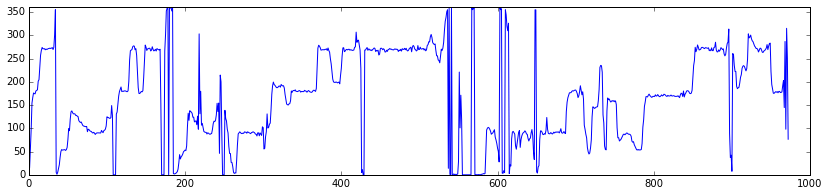

In [15]:
plt.figure(figsize=(14,3))
plt.plot(bear)
plt.ylim(0,360)

In [16]:
from coordinateSystems import GeographicSystem
alt = np.zeros_like(lat_deg)

In [17]:
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon_deg, lat_deg, alt) # Use degrees
stack = np.vstack((X,Y,Z))

In [18]:
lat0, lon0 = (33.5783465, -101.8954462) # centered at the Fixed Site
from coordinateSystems import TangentPlaneCartesianSystem

tangent = TangentPlaneCartesianSystem(ctrLat=lat0,ctrLon=lon0,ctrAlt=978)
local = (tangent.toLocal(stack))

In [19]:
local2 = local[:,:].T # The local coords transposed

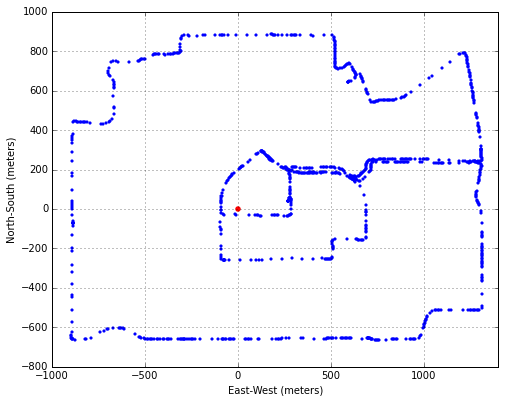

In [20]:
fig = plt.figure(figsize=(8,14))
ax = fig.add_subplot(211)
ax.set_xlim(-1000,1400)

ax.scatter(0,0,c='r',s=30,linewidths=0)
for i in range(0,972):
    ax.scatter(local2[i,:2][0],local2[i,:2][1],s=10,linewidths=0)
    #ax.barbs(local2[i,:2][0],local2[i,:2][1],2,2,linewidth=0.1)
    #ax.quiver(local2[i,:2][0],local2[i,:2][1],2,2,linewidth=0,width=0.001,headwidth=15)

ax.set_xlabel('East-West (meters)')
ax.set_ylabel('North-South (meters)')
ax.grid()

In [21]:
# calculate u and v components from direction
rad = (bear)*(np.pi/180)
u = np.sin(rad)
v = np.cos(rad)

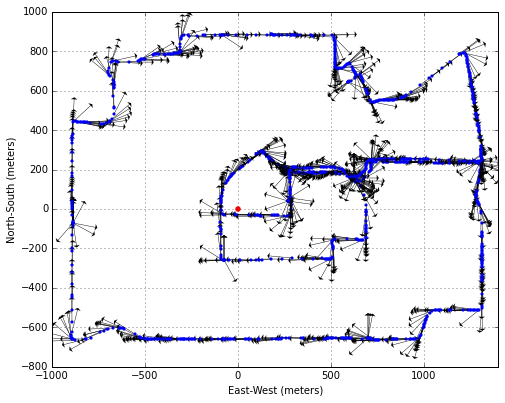

In [22]:
fig = plt.figure(figsize=(8,14))
ax = fig.add_subplot(211)
ax.set_xlim(-1000,1400)

ax.scatter(0,0,c='r',s=30,linewidths=0)
for i in range(0,972):
    ax.scatter(local2[i,:2][0],local2[i,:2][1],s=10,linewidths=0)
    #ax.barbs(local2[i,:2][0],local2[i,:2][1],2,2,linewidth=0.1)
    ax.quiver(local2[i,:2][0],local2[i,:2][1],u[i],v[i],linewidth=0,width=0.001,headwidth=15)

ax.set_xlabel('East-West (meters)')
ax.set_ylabel('North-South (meters)')
ax.grid()

In [23]:
type(timestamp[0])

str

In [27]:
# Setting in the time offsets
gpstime = []
for i in range(0,len(timestamp)):
    ddt = datetime.datetime.strptime(timestamp[i],"%Y-%m-%d %H:%M:%S")
    adj = ddt + datetime.timedelta(hours=-7)
    gpstime = np.append(str(adj),gpstime)
gpstime = gpstime[::-1]

In [28]:
gpstime[0]

'2016-05-06 15:56:36'